In [1]:
import sys
sys.path.append('..')
import config as conf
import functions.notebook_helper_functions.notebook15 as funcs

paths = conf.DataFilePaths()
params = conf.GRU_model_parameters()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

<a name="block_size"></a>
### 1. Experiment 1: block size by GRU units and learning rate

In [2]:
SMAPE_scores_df = pd.read_parquet(params.optimization_data_output_file)

SMAPE_scores_df = SMAPE_scores_df.astype({
    'GPU': int, 
    'Run number': int,
    'Iteration': int,
    'Block size': int,
    'GRU units': int
})

SMAPE_scores_df.head()

,GPU,Run number,Iteration,Block size,GRU units,Learning rate,GRU private SMAPE score,Control private SMAPE score,GRU public SMAPE score,Control public SMAPE score
0,2,2,2,9,16,0.001,13.291943,3.352635,15.229593,1.460999
1,0,0,0,9,16,0.001,11.195302,3.352635,11.769314,1.460999
2,3,3,3,9,16,0.001,11.625521,3.352635,13.953326,1.460999
3,1,1,1,9,16,0.001,9.963893,3.352635,12.235867,1.460999
4,2,4,4,9,16,0.001,9.799920,3.352635,11.660292,1.460999


In [5]:
def SMAPE_score_boxplot(
    SMAPE_scores_df: pd.DataFrame,
    parameter: str = 'Block size',
    hue_by: str = 'Learning rate'
):

    # Get the best control SMAPE score from this experiment so that we can add
    # it to the plots for comparison
    mean_SMAPE_scores_df = SMAPE_scores_df.groupby([
        'Block size', 
        'GRU units', 
        'Learning rate'
    ])[[
        'Control private SMAPE score', 
        'Control public SMAPE score',
        'GRU private SMAPE score', 
        'GRU public SMAPE score'
    ]].mean()

    mean_SMAPE_scores_df.reset_index(inplace=True, drop=False)

    winning_control_mean_public_SMAPE = mean_SMAPE_scores_df.sort_values(by=['Control public SMAPE score'])
    winning_control_mean_public_SMAPE.reset_index(inplace=True, drop=True)
    winning_control_mean_public_SMAPE = winning_control_mean_public_SMAPE['Control public SMAPE score'].iloc[0]

    winning_control_mean_private_SMAPE = mean_SMAPE_scores_df.sort_values(by=['Control private SMAPE score'])
    winning_control_mean_private_SMAPE.reset_index(inplace=True, drop=True)
    winning_control_mean_private_SMAPE = winning_control_mean_private_SMAPE['Control private SMAPE score'].iloc[0]

    print()
    print(f'Winning control mean public SMAPE scores: {winning_control_mean_public_SMAPE}')
    print(f'Winning control mean private SMAPE score: {winning_control_mean_private_SMAPE}')
    print()

    # Get condition levels 
    parameters = {
        'Block size': list(mean_SMAPE_scores_df['Block size'].unique()),
        'GRU units': list(mean_SMAPE_scores_df['GRU units'].unique()),
        'Learning rate': list(mean_SMAPE_scores_df['Learning rate'].unique())
    }

    for parameter_name, levels in parameters.items():
        print(f'{parameter_name}: {levels}')

    print()

    # Find the experiment-wide max and min SMAPE score so that we can set a common Y-scale for all
    # of the subplots
    public_SMAPE_scores = list(SMAPE_scores_df['Control public SMAPE score']) + list(SMAPE_scores_df['GRU public SMAPE score'])
    public_SMAPE_scores = [i for i in public_SMAPE_scores if i > 0]
    max_public_SMAPE_score = max(public_SMAPE_scores)
    min_public_SMAPE_score = min(public_SMAPE_scores)

    private_SMAPE_scores = list(SMAPE_scores_df['Control private SMAPE score']) + list(SMAPE_scores_df['GRU private SMAPE score'])
    private_SMAPE_scores = [i for i in private_SMAPE_scores if i > 0]
    max_private_SMAPE_score = max(private_SMAPE_scores)
    min_private_SMAPE_score = min(private_SMAPE_scores)

    # Plot public SMAPE score
    fig, ax = plt.subplots(len(parameters[parameter]), 1, figsize=(12, (3.5 * len(parameters[parameter]))))

    for plot_num, parameter_level in enumerate(parameters[parameter]):

        sns.boxplot(
            data=SMAPE_scores_df[SMAPE_scores_df[parameter] == parameter_level], 
            x='GRU units',
            y='GRU public SMAPE score',
            hue=hue_by,
            ax=ax
        )

        # Set common y limit
        ax.set_ylim([min_public_SMAPE_score - (0.1*min_public_SMAPE_score), max_public_SMAPE_score + (0.1*max_public_SMAPE_score)])

        # Add line for best control sample mean
        ax.axhline(winning_control_mean_public_SMAPE, 0, 1, color='red', label=f'Best control mean\npublic SMAPE score')
        
        ax.set(yscale='log')

        # Labels
        ax.set(
            xlabel='GRU units', 
            ylabel='Public SMAPE score', 
            title=f'{parameter} {parameter_level}'
        )

        # Put a legend to the right of the current axis
        ax.legend(title=hue_by, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.suptitle('Public SMAPE score')
    plt.tight_layout()

    # Plot private SMAPE score
    fig, ax = plt.subplots(len(parameters[parameter]), 1, figsize=(12, (3.5 * len(parameters[parameter]))))

    for plot_num, parameter_level in enumerate(parameters[parameter]):

        sns.boxplot(
            data=SMAPE_scores_df[SMAPE_scores_df[parameter] == parameter_level], 
            x='GRU units',
            y='GRU private SMAPE score',
            hue=hue_by,
            ax=ax
        )

        # Set common y limit
        ax.set_ylim([min_private_SMAPE_score - (0.1*min_private_SMAPE_score), max_private_SMAPE_score + (0.1*max_private_SMAPE_score)])

        # Add line for best control sample mean
        ax.axhline(winning_control_mean_private_SMAPE, 0, 1, color='red', label=f'Best control mean\nprivate SMAPE score')
        
        ax.set(yscale='log')

        # Labels
        ax.set(
            xlabel='GRU units', 
            ylabel='Private SMAPE score', 
            title=f'{parameter} {parameter_level}'
        )

        # Put a legend to the right of the current axis
        ax.legend(title=hue_by, bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.suptitle('Private SMAPE score')
    plt.tight_layout()

    return True


Winning control mean public SMAPE scores: 1.4609987048968616
Winning control mean private SMAPE score: 3.3526346380211067

Block size: [9]
GRU units: [16, 32, 64]
Learning rate: [1e-05, 0.0001, 0.001]



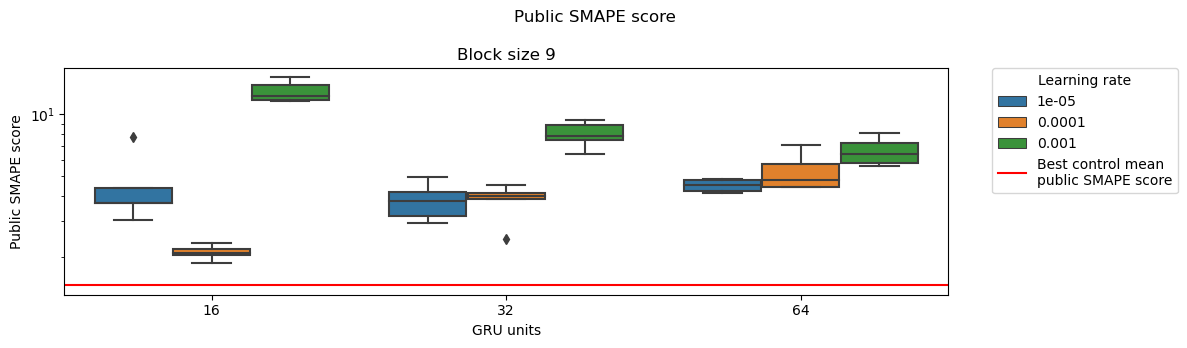

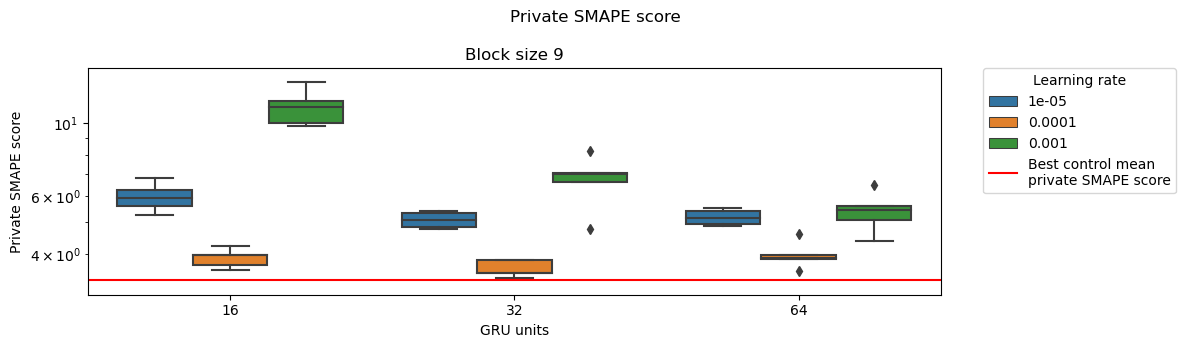

In [6]:
_ = SMAPE_score_boxplot(
    SMAPE_scores_df,
    parameter = 'Block size',
    hue_by = 'Learning rate'
)